<a href="https://colab.research.google.com/github/Lucia1009/TFG-Plataforma-para-la-prediccion-de-potencia-electrica-generada-en-parques-eolicos/blob/desarrollo/modelos/Comparacion_modelos_series_temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openmeteo-requests -q
!pip install requests-cache retry-requests numpy pandas -q

!pip install dash -q

In [2]:
import openmeteo_requests

import requests_cache
import pandas as pd
import numpy as np
from retry_requests import retry

from dash import Dash, html, dcc, Input, Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

import sys
import math

rosa='\033[95m'
fin='\033[0m'

# Cargar el histórico

In [3]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2023-01-01",
	"end_date": "2024-12-31",
	"hourly": ["temperature_2m", "wind_speed_10m", "wind_direction_10m"],
	"models": "best_match"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(2).ValuesAsNumpy()


hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m



historico_df = pd.DataFrame(data = hourly_data)


# No hay nan, pero por si acaso
historico_df.dropna(inplace = True)

historico_df['wd_sin_10m'] = np.sin(historico_df['wind_direction_10m']*np.pi/180)
historico_df['wd_cos_10m'] = np.cos(historico_df['wind_direction_10m']*np.pi/180)


historico_df.head()

Coordinates 52.5483283996582°N 13.407821655273438°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,temperature_2m,wind_speed_10m,wind_direction_10m,wd_sin_10m,wd_cos_10m
0,2023-01-01 00:00:00+00:00,15.3085,30.532158,232.184204,-0.789986,-0.613125
1,2023-01-01 01:00:00+00:00,15.7085,30.699368,230.710602,-0.773958,-0.633237
2,2023-01-01 02:00:00+00:00,15.7585,31.259941,231.546265,-0.783111,-0.621882
3,2023-01-01 03:00:00+00:00,15.8585,28.394392,230.659500,-0.773392,-0.633928
4,2023-01-01 04:00:00+00:00,15.8085,28.266304,223.451889,-0.687745,-0.725952




---


# Datos de los modelos
Los modelos seleccionados son:

['ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km']

1. *ECMWF IFS 0.4°*
2. *NCEP GFS Global 0.11°/0.25°*
3. *JMA GSM*
4. *DWD ICON Global*
5. *DWD ICON EU*
6. *DWD ICON D2*
7. *GEM Global*
8. *UK Met Office Global 10km*
9. *Météo-France ARPEGE Europe*
10. *Météo-France AROME France HD*




In [4]:
lista_modelos=['best_match','ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km']

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2023-01-01",
	"end_date": "2024-12-31",
	"hourly": ["temperature_2m", "wind_speed_10m", "wind_direction_10m"],
	"models": lista_modelos
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
models=dict()
for response, mod in zip(responses, lista_modelos):

  print(f"{rosa}Model {mod}{fin}")  #Imprime con colores
  print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
  print(f"Elevation {response.Elevation()} m asl")
  print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
  print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s\n")


  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
  hourly_wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()
  hourly_wind_direction_10m = hourly.Variables(2).ValuesAsNumpy()

  hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
  )}

  hourly_data["temperature_2m"] = hourly_temperature_2m
  hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
  hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  hourly_dataframe.dropna(inplace = True)

  hourly_dataframe['wd_sin_10m'] = np.sin(hourly_dataframe['wind_direction_10m']*np.pi/180)
  hourly_dataframe['wd_cos_10m'] = np.cos(hourly_dataframe['wind_direction_10m']*np.pi/180)

  models[mod]=hourly_dataframe
  print(hourly_dataframe.iloc[0], '\n\n')

print(len(models))
print(models.keys())

Model best_match
Coordinates 52.52000045776367°N 13.419998168945312°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s

date                  2023-01-01 00:00:00+00:00
temperature_2m                        15.945499
wind_speed_10m                        20.390114
wind_direction_10m                   222.137527
wd_sin_10m                            -0.670913
wd_cos_10m                            -0.741536
Name: 0, dtype: object 


Model ecmwf_ifs04
Coordinates 52.40000915527344°N 13.600006103515625°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s

date                  2023-01-01 00:00:00+00:00
temperature_2m                             15.7
wind_speed_10m                        29.671074
wind_direction_10m                   234.381424
wd_sin_10m                            -0.812912
wd_cos_10m                            -0.582386
Name: 0, dtype: object 


Model gfs_global
Coordinates 52.54148864746094°N 13.359375°E
Elevation 38.0 m asl
T

In [5]:
# todos=historico_df.copy()
# for mod in models.keys():
#   todos=todos.merge(models[mod], on="date", how="left", suffixes=("", f"_{mod}"),)

# todos.head(20)




---

# Obtener las métricas de cada modelo

In [27]:
# Obtengo el error de la dirección a través del error del seno y el coseno

def diferencia_angulos(sin_real, cos_real, sin_pagina, cos_pagina):

    producto_escalar = sin_real * sin_pagina + cos_real * cos_pagina
    producto_escalar = max(-1.0, min(1.0, producto_escalar))
    angulo_rad = math.acos(producto_escalar)
    angulo_deg = math.degrees(angulo_rad)
    return angulo_deg



In [46]:
atribs=['temperature_2m', 'wind_speed_10m', 'wd_sin_10m', 'wd_cos_10m']
atributos=['temperature_2m', 'wind_speed_10m']

def obtener_metricas(historico_df, models):

  scores=dict()
  error_angulos=dict()

  for mod in models.keys():

    print(f"\n{rosa}Model {mod}{fin}")
    print(f'maxima direccion', models[mod]['wind_direction_10m'].max())
    print(f'minima direccion', models[mod]['wind_direction_10m'].min())
    scores[mod]=dict()

    hist_df=historico_df.copy()

    for atributo in atributos:

      datos_trabajo_model=hist_df.merge(models[mod], on="date", how="left", suffixes=("", f"_{mod}"),)
      datos_trabajo_model.dropna(inplace=True)

      y_true=datos_trabajo_model[atributo]
      y_pred_model=datos_trabajo_model[atributo+f"_{mod}"]
      rmse = np.sqrt(mean_squared_error(y_true, y_pred_model))
      mae = mean_absolute_error(y_true, y_pred_model)
      r2 = r2_score(y_true, y_pred_model)
      mx_error = max_error(y_true, y_pred_model)


      print(f"{atributo}: rmse: {rmse}, mae: {mae}, r2: {r2}, max_error:{mx_error}")
      scores[mod][atributo]={'rmse':rmse, 'mae':mae, 'r2':r2, 'max_error':mx_error}

      error_angulos[mod]=[diferencia_angulos(datos_trabajo_model['wd_sin_10m'][k], datos_trabajo_model['wd_cos_10m'][k], datos_trabajo_model['wd_sin_10m'+f"_{mod}"][k], datos_trabajo_model['wd_cos_10m'+f"_{mod}"][k]) for k in datos_trabajo_model.index]

  return scores, error_angulos

scores, error_angulos=obtener_metricas(historico_df, models)


Model best_match
maxima direccion 360.0
minima direccion 1.4320632219314575
temperature_2m: rmse: 1.0753085625068393, mae: 0.7936776280403137, r2: 0.9818861484527588, max_error:8.713001251220703
wind_speed_10m: rmse: 4.832111774288624, mae: 4.056494235992432, r2: 0.466105580329895, max_error:19.983684539794922

Model ecmwf_ifs04
maxima direccion 360.0
minima direccion 1.0416086912155151
temperature_2m: rmse: 0.6796604019551079, mae: 0.4823457896709442, r2: 0.9927635192871094, max_error:5.141499996185303
wind_speed_10m: rmse: 2.4100743408133845, mae: 1.7880427837371826, r2: 0.8671864867210388, max_error:19.41615867614746

Model gfs_global
maxima direccion 360.0
minima direccion 0.7440446615219116
temperature_2m: rmse: 1.4579831202384157, mae: 1.0749601125717163, r2: 0.9666996002197266, max_error:8.64999771118164
wind_speed_10m: rmse: 2.743634920596151, mae: 2.0643346309661865, r2: 0.8278789520263672, max_error:20.52653694152832

Model jma_gsm
maxima direccion 360.0
minima direccion 0.8

# Histograma de resultados

<ipython-input-38-ea3cd0e7aeca>:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



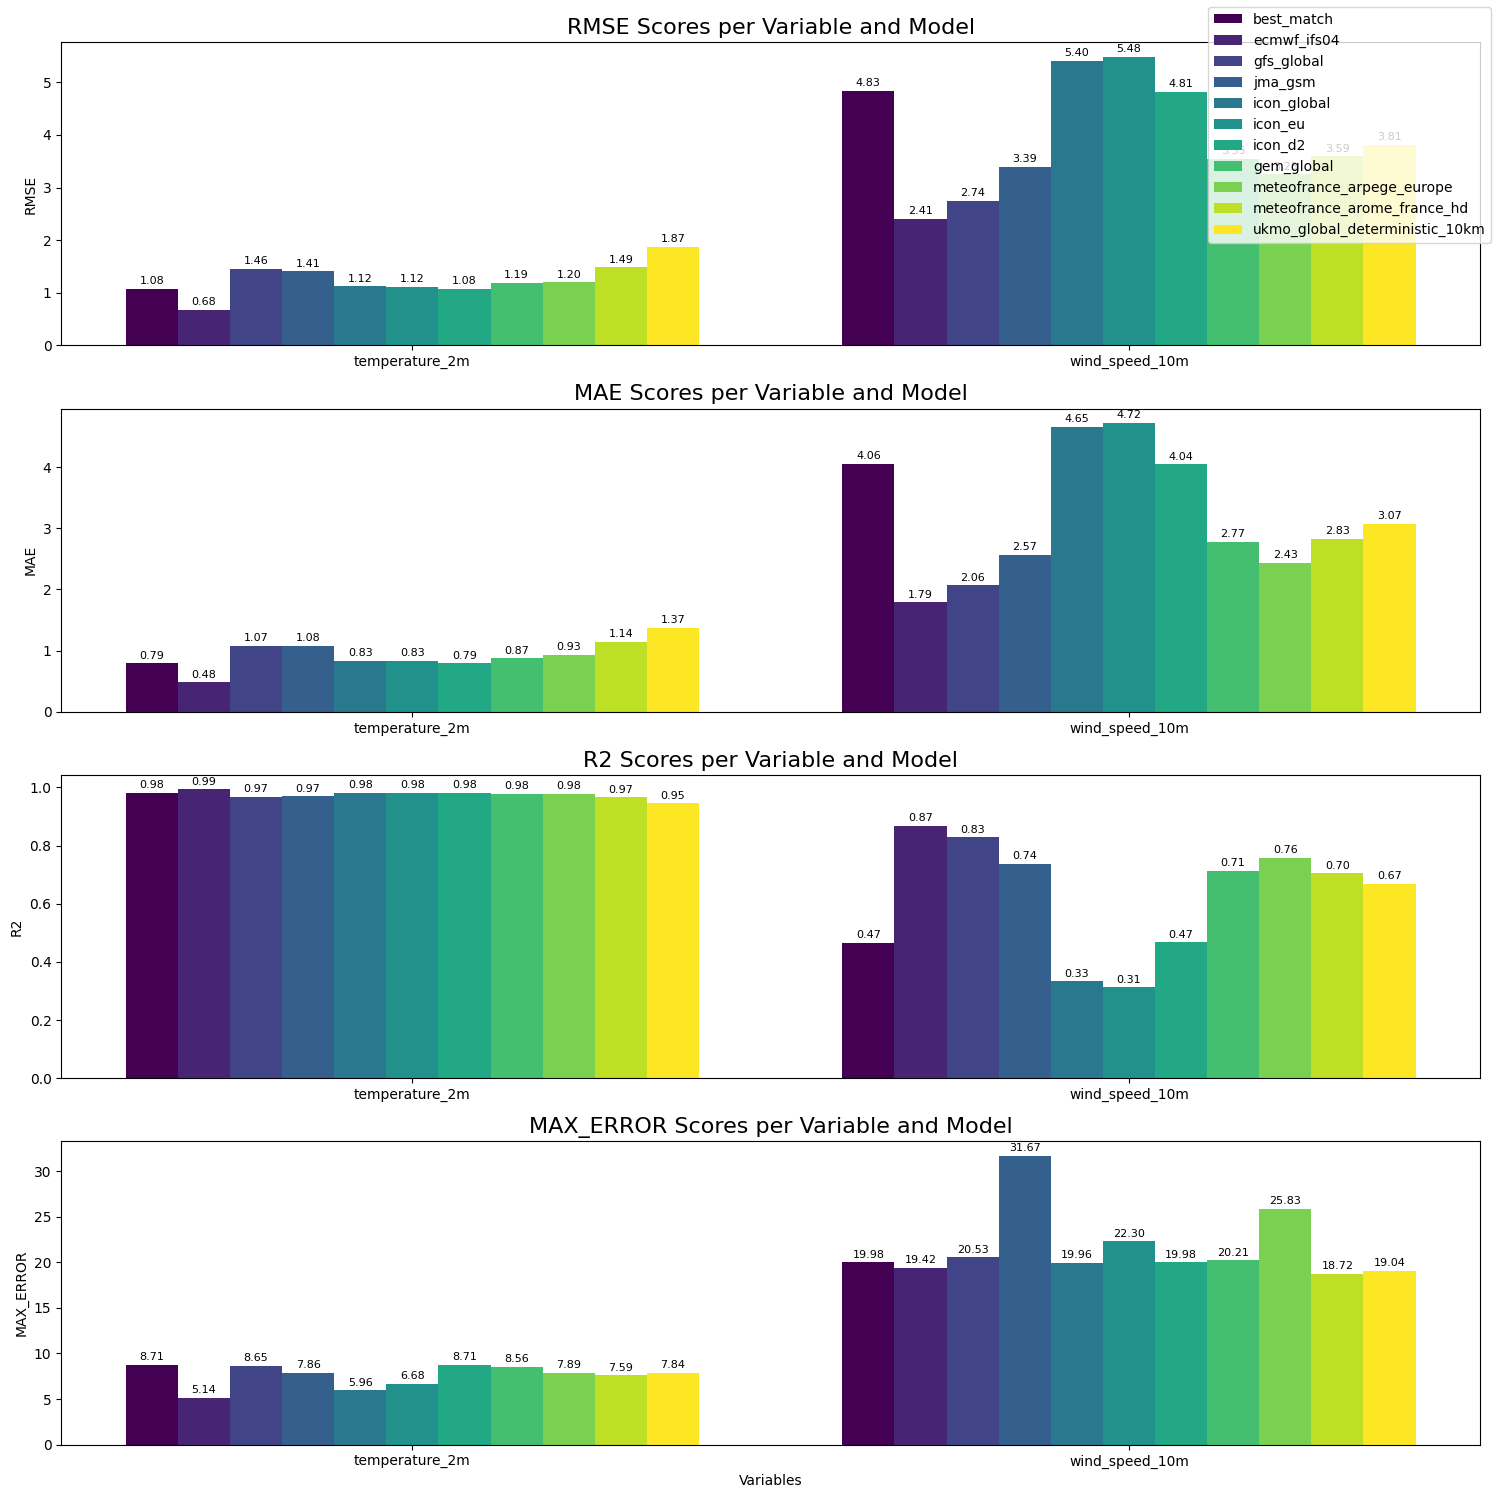

<Figure size 640x480 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt

def graficar_metricas(scores, nombre=None):

  lista_modelos = list(scores.keys())

  # Define colors for each model
  model_colors = plt.cm.get_cmap('viridis', len(lista_modelos))
  model_colors = [model_colors(i) for i in range(len(lista_modelos))]
  model_colors_dict = dict(zip(lista_modelos, model_colors))

  # Define metrics
  metrics = ['rmse', 'mae', 'r2', 'max_error'] # Changed to lowercase

  # Define the bar width and position offset for each model
  bar_width = 0.8 / len(lista_modelos)

  # Calculate the positions for each bar
  def calculate_bar_positions(variable_index, model_index):
      group_center = variable_index
      offset = (model_index - len(lista_modelos) / 2 + 0.5) * bar_width
      return group_center + offset

  # Create the figure and subplots
  fig, axes = plt.subplots(len(metrics), 1, figsize=(15, 15))

  # Loop through each metric and variable, and plot the bars
  for metric_index, metric in enumerate(metrics):
      for variable_index, variable in enumerate(atributos):
          for model_index, model in enumerate(lista_modelos):

              score = scores[model][variable][metric] # Access using metric name
              bar_position = calculate_bar_positions(variable_index, model_index)
              bars = axes[metric_index].bar(bar_position, score, width=bar_width, color=model_colors_dict[model], label=model if variable_index == 0 else "")
              axes[metric_index].bar_label(bars, fmt='%.2f', label_type='edge', padding=2, fontsize=8)

      axes[metric_index].set_ylabel(metric.upper()) # Convert to uppercase for label
      axes[metric_index].set_title(f'{metric.upper()} Scores per Variable and Model', fontsize=16)
      # Set the x-axis labels and ticks for each subplot
      axes[metric_index].set_xticks(range(len(atributos)))
      axes[metric_index].set_xticklabels(atributos)


  # Set the x-axis label for the bottom plot
  axes[-1].set_xlabel("Variables")

  # Add a legend
  handles, labels = axes[0].get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper right')

  # Adjust the layout and display the plot
  plt.tight_layout()
  plt.show()

  # Guardar plot
  if nombre is not None:
    plt.savefig(nombre, dpi=300)

graficar_metricas(scores, 'comparacion_modelos_series_temporales.png')




---
# Comparación 1 hora antes


In [39]:
def obtener_atraso(historico_df, models):

  scores_atraso=dict()
  datos_atraso_dict = {}  # Create a dictionary to store the delayed dataframes
  for mod in models.keys():

    #print(f"\n{rosa}Model {mod}{fin}")
    scores_atraso[mod]=dict()

    hist_df=historico_df.copy()

    for atributo in atributos:
      # Atraso una hora todos los datos del modelo
      datos_atraso=models[mod].copy()
      datos_atraso['date']=datos_atraso['date']-pd.Timedelta(hours=1)
    datos_atraso_dict[mod] = datos_atraso  # Store the delayed dataframe in the dictionary
  return datos_atraso_dict

datos_atraso=obtener_atraso(historico_df, models)
scores_atraso, error_angulos_atraso=obtener_metricas(historico_df, datos_atraso)
#

#       datos_trabajo_1h=hist_df.merge(datos_atraso, on="date", how="left", suffixes=("", f"_{mod}"),)
#       datos_trabajo_1h.dropna(inplace=True)
#       y_true=datos_trabajo_1h[atributo]
#       y_pred_1h=datos_trabajo_1h[atributo+f"_{mod}"]
#       mse = mean_squared_error(y_true, y_pred_1h)
#       mae = mean_absolute_error(y_true, y_pred_1h)
#       r2 = r2_score(y_true, y_pred_1h)

#       print(f"{atributo}: mse: {mse}, mae: {mae}, r2: {r2}")
#       scores_atraso[mod][atributo]={'mse':mse, 'mae':mae, 'r2':r2}

#   return scores_atraso

# scores_atraso=obtener_metricas_atraso(historico_df, models)






Model best_match
maxima direccion 360.0
minima direccion 1.4320632219314575
temperature_2m: rmse: 1.0075914598889764, mae: 0.7590582966804504, r2: 0.9840949773788452, max_error:7.062999725341797
wind_speed_10m: rmse: 4.908905865492294, mae: 4.09719181060791, r2: 0.449012815952301, max_error:21.175579071044922

Model ecmwf_ifs04
maxima direccion 360.0
minima direccion 1.0416086912155151
temperature_2m: rmse: 0.9934356528160295, mae: 0.7247905731201172, r2: 0.984538733959198, max_error:6.508501052856445
wind_speed_10m: rmse: 2.630898252340113, mae: 1.947131633758545, r2: 0.8417366743087769, max_error:17.894214630126953

Model gfs_global
maxima direccion 360.0
minima direccion 0.7440446615219116
temperature_2m: rmse: 1.5791134146751018, mae: 1.1913269758224487, r2: 0.9609346389770508, max_error:8.950000762939453
wind_speed_10m: rmse: 2.9207348562519164, mae: 2.1994199752807617, r2: 0.8049453496932983, max_error:23.515289306640625

Model jma_gsm
maxima direccion 360.0
minima direccion 0.8

In [40]:
verde='\033[92m'  #Mejor con los datos reales del momento
rojo='\033[91m'   #Mejor con los datos del momento anterior

for mod in models.keys():
  print(f"\n\n\n{rosa}Model {mod}{fin}")
  for atributo in atributos:
    print(f"\n{atributo}")
    for metrica in scores_atraso[mod][atributo]: #iteramos por los nombres de las métricas
      resta=scores[mod][atributo][metrica]-scores_atraso[mod][atributo][metrica]
      porcentaje=resta/scores[mod][atributo][metrica]
      if metrica != 'r2' and resta>0 or metrica == 'r2' and resta<0:
         print(f'{rojo}resta {metrica}{fin}', resta, 'porcentaje', porcentaje)
      else:
         print(f'{verde}resta {metrica}{fin}', resta, 'porcentaje', porcentaje)





Model best_match

temperature_2m
resta rmse 0.0677171026178629 porcentaje 0.0629745776970247
resta mae 0.03461933135986328 porcentaje 0.04361888270095581
resta r2 -0.0022088289260864258 porcentaje -0.0022495774378394734
resta max_error 1.6500015 porcentaje 0.18937235

wind_speed_10m
resta rmse -0.07679409120366998 porcentaje -0.015892449262512248
resta mae -0.040697574615478516 porcentaje -0.010032696276103977
resta r2 0.017092764377593994 porcentaje 0.03667144333585594
resta max_error -1.1918945 porcentaje -0.05964338



Model ecmwf_ifs04

temperature_2m
resta rmse -0.3137752508609216 porcentaje -0.46166475192363304
resta mae -0.24244478344917297 porcentaje -0.502636881343089
resta r2 0.008224785327911377 porcentaje 0.00828473767228825
resta max_error -1.367001 porcentaje -0.26587594

wind_speed_10m
resta rmse -0.22082391152672853 porcentaje -0.09162535270683887
resta mae -0.1590888500213623 porcentaje -0.08897373791518075
resta r2 0.025449812412261963 porcentaje 0.0293475657219838

# Cuenta número de datos mejores

In [41]:
def más_error(a, b, c):
  if abs(a-b) > abs(a-c):
    return 1
  else:
    return 0

hist_df=historico_df.copy()

def cuenta_mejores(hist_df, models, datos_atraso):
  cuenta=pd.DataFrame(columns=['Modelo', 'Atributo', 'Cuenta_peor_1h', 'Cuenta_peor_Model', 'Cuenta_iguales'])
  for mod in models.keys():

    for atributo in atributos:
      # Uno los datos del modelo con los datos históricos y borro los nulos
      datos_trabajo_model=hist_df.merge(models[mod], on="date", how="left", suffixes=("", f"_{mod}"),)
      datos_trabajo_model.dropna(inplace=True)

      # Uno a los datos unidos los datos de 1 hora antes y borro los nulos
      datos_trabajo=datos_trabajo_model.merge(datos_atraso[mod], on="date", how="left", suffixes=("", f"_{mod}"),)
      datos_trabajo.dropna(inplace=True)

      # De todos los datos mezclados tomo los valores
      y_true=datos_trabajo[atributo]
      y_pred=datos_trabajo[atributo+f"_{mod}"]
      y_pred_model=y_pred.iloc[:,0]
      y_pred_1h=y_pred.iloc[:,1]

      # Cuento las veces que cada uno es mejor
      cuenta_1h = np.sum(np.fromiter((más_error(y_true.iloc[k], y_pred_1h.iloc[k], y_pred_model.iloc[k]) for k in range(len(y_true))), dtype=float))
      cuenta_model = np.sum(np.fromiter((más_error(y_true.iloc[k], y_pred_model.iloc[k], y_pred_1h.iloc[k]) for k in range(len(y_true))), dtype=float))
      cuenta_iguales=len(y_true)-cuenta_1h-cuenta_model
      cuenta.loc[len(cuenta)] = [mod, atributo, cuenta_1h, cuenta_model, cuenta_iguales]
      # print(len(y_true),cuenta_1h+cuenta_model+cuenta_iguales)
  return cuenta

cuenta=cuenta_mejores(hist_df, models, datos_atraso)
cuenta



,Modelo,Atributo,Cuenta_peor_1h,Cuenta_peor_Model,Cuenta_iguales
0,best_match,temperature_2m,7742.0,9180.0,621.0
1,best_match,wind_speed_10m,8664.0,8592.0,287.0
2,ecmwf_ifs04,temperature_2m,10889.0,6021.0,633.0
3,ecmwf_ifs04,wind_speed_10m,9369.0,7765.0,409.0
4,gfs_global,temperature_2m,8371.0,8204.0,968.0
5,gfs_global,wind_speed_10m,9297.0,7980.0,266.0
6,jma_gsm,temperature_2m,7614.0,9273.0,656.0
7,jma_gsm,wind_speed_10m,8500.0,8244.0,799.0
8,icon_global,temperature_2m,7362.0,9564.0,617.0
9,icon_global,wind_speed_10m,8531.0,8370.0,642.0


In [47]:
"""Gráfica de datos para cada modelo y variable"""

app = Dash('app1')

app.layout = html.Div([

  dcc.Dropdown(lista_modelos, lista_modelos[0], id='modelo', clearable=False),
  dcc.Dropdown(atribs, atribs[0], id='atributo', clearable=False),
  dcc.Checklist(
          id='ver_error',
          options=[{'label': 'Cambiar a visualizar error', 'value': 'error'}],
          value=[]
  ),

  dcc.Graph(id='graph')
])


@app.callback(
    Output('graph', 'figure'),
    Input('modelo', 'value'),
    Input('atributo', 'value'),
    Input('ver_error', 'value'))
def update_output_div(modelo, atributo, ver_error):

  # Crear figura base

  fig = go.Figure()

  datos_trabajo_model=hist_df.merge(models[modelo], on="date", how="left", suffixes=("", f"_{modelo}"),)
  datos_trabajo_model.dropna(inplace=True)

  y_true=datos_trabajo_model[atributo]
  y_pred_model=datos_trabajo_model[atributo+f"_{modelo}"]


  if 'error' in ver_error:
    if atributo != 'wd_sin_10m' and atributo != 'wd_cos_10m':
      fig.add_trace(go.Scatter(y=y_true-y_pred_model, mode='lines', marker=dict(color='red'), name='Error'))
      fig.update_layout(
          title='Error historico vs prediccion',
          transition_duration=10,
          xaxis_title='tiempo (h)',
          yaxis_title=f'Error{atributo}'
      )
    else:
      fig.add_trace(go.Scatter(y=error_angulos[modelo], mode='lines', marker=dict(color='red'), name='Error ángulo'))
  else:
    fig.add_trace(go.Scatter(y=y_pred_model, mode='lines', marker=dict(color='red'), name='Predichas'))
    fig.add_trace(go.Scatter(y=y_true, mode='lines', marker=dict(color='blue'), opacity=0.5, name='Historicas'))

    fig.update_layout(
        title='Historico vs prediccion',
        transition_duration=10,
        xaxis_title='tiempo (h)',
        yaxis_title=f'{atributo}'
    )


  return fig



if __name__ == '__main__':
    app.run_server(debug=True, port=8071)


<IPython.core.display.Javascript object>



---


# Comparación de predicciones y datos reales actuales

In [13]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

lista_modelos=["best_match", "ecmwf_ifs04", "gfs_global", "jma_gsm", "icon_global", "icon_eu", "icon_d2", "gem_global", "meteofrance_arpege_europe", "meteofrance_arome_france_hd", "ukmo_global_deterministic_10km"]

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
# url = "https://api.open-meteo.com/v1/forecast"
url="https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
  "start_date": "2025-03-03", #historico
	"end_date": "2025-03-13",  #historico
	"hourly": ["temperature_2m", "wind_speed_10m", "wind_direction_10m"],
	# "forecast_days": 16,  #Predicciones
	"models": lista_modelos
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
modelos=dict()
for response, mod in zip(responses, lista_modelos):


  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
  hourly_wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()
  hourly_wind_direction_10m = hourly.Variables(2).ValuesAsNumpy()

  hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
  )}

  hourly_data["temperature_2m"] = hourly_temperature_2m
  hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
  hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  hourly_dataframe.dropna(inplace = True)

  hourly_dataframe['wd_sin_10m'] = np.sin(hourly_dataframe['wind_direction_10m']*np.pi/180)
  hourly_dataframe['wd_cos_10m'] = np.cos(hourly_dataframe['wind_direction_10m']*np.pi/180)

  modelos[mod]=hourly_dataframe.to_dict(orient='list')


print(len(modelos))
print(modelos.keys())

# Guardo modelos
import pickle

# nombre_archivo = 'models.pkl'
nombre_archivo = 'models_hist.pkl'

with open(nombre_archivo, 'wb') as f:
    pickle.dump(modelos, f)


11
dict_keys(['best_match', 'ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km'])


In [14]:
# models_pred=pd.read_csv('/content/open-meteo-52.52N13.42E38m.csv', skiprows=3)
# models_hist=pd.read_csv('/content/open-meteo-52.52N13.42E38m_hist.csv', skiprows=3)
# models_pred['time']=pd.to_datetime(models_pred['time'])
# models_hist['time']=pd.to_datetime(models_hist['time'])
# print(models_pred['time'].max())
# print(models_hist['time'].max())
# print(models_pred['time'].min())
# print(models_hist['time'].min())

In [17]:
import pickle

# abro models
with open('models_hist.pkl', 'rb') as f:
    models_hist = pickle.load(f)
with open('models.pkl', 'rb') as f:
    models_pred = pickle.load(f)

print(len(models_hist))
print(len(models_pred))
print(models_hist.keys())
print(models_pred.keys())

for mod in models_hist.keys():
  models_hist[mod]=pd.DataFrame(models_hist[mod])
  models_pred[mod]=pd.DataFrame(models_hist[mod])


11
11
dict_keys(['best_match', 'ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km'])
dict_keys(['best_match', 'ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km'])


In [18]:
# scores_nuevos=obtener_metricas(models_hist['best_match'], models_pred)
print(models_hist['best_match']['date'].min())
print(models_pred['best_match']['date'].min())
print(models_hist['best_match']['date'].max())
print(models_pred['best_match']['date'].max())

models_pred['best_match'].tail()

2025-03-03 00:00:00+00:00
2025-03-03 00:00:00+00:00
2025-03-05 00:00:00+00:00
2025-03-05 00:00:00+00:00


,date,temperature_2m,wind_speed_10m,wind_direction_10m,wd_sin_10m,wd_cos_10m
44,2025-03-04 20:00:00+00:00,4.6085,10.304114,242.987411,-0.890907,-0.454186
45,2025-03-04 21:00:00+00:00,3.7085,8.863972,257.092590,-0.974732,-0.223376
46,2025-03-04 22:00:00+00:00,3.0585,9.676570,260.362518,-0.985887,-0.167414
47,2025-03-04 23:00:00+00:00,2.6585,9.914717,266.877930,-0.998516,-0.054464
48,2025-03-05 00:00:00+00:00,2.3085,9.224011,252.979385,-0.956200,-0.292716



Model best_match
maxima direccion 279.4622497558594
minima direccion 235.2440185546875
temperature_2m: rmse: 1.9706937913649853, mae: 1.664632527803888, r2: 0.5315120836326761, max_error:3.4870004653930664
wind_speed_10m: rmse: 2.1495928122558134, mae: 1.842436206584074, r2: 0.43230727450652373, max_error:4.71541166305542

Model ecmwf_ifs04
maxima direccion 282.99462890625
minima direccion 209.7447967529297
temperature_2m: rmse: 3.262760603491374, mae: 2.7462707410256066, r2: 0.39913894531191396, max_error:7.795499801635742
wind_speed_10m: rmse: 10.191211407166026, mae: 8.583629245559374, r2: -11.052270411751653, max_error:17.99254035949707

Model gfs_global
maxima direccion 285.2551574707031
minima direccion 204.44393920898438
temperature_2m: rmse: 1.494369227744573, mae: 1.237604013333718, r2: 0.8739567861906995, max_error:3.6369991302490234
wind_speed_10m: rmse: 2.7513459813486474, mae: 2.457083503405253, r2: 0.12156899063742421, max_error:6.289039611816406

Model jma_gsm
maxima di

<ipython-input-38-ea3cd0e7aeca>:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



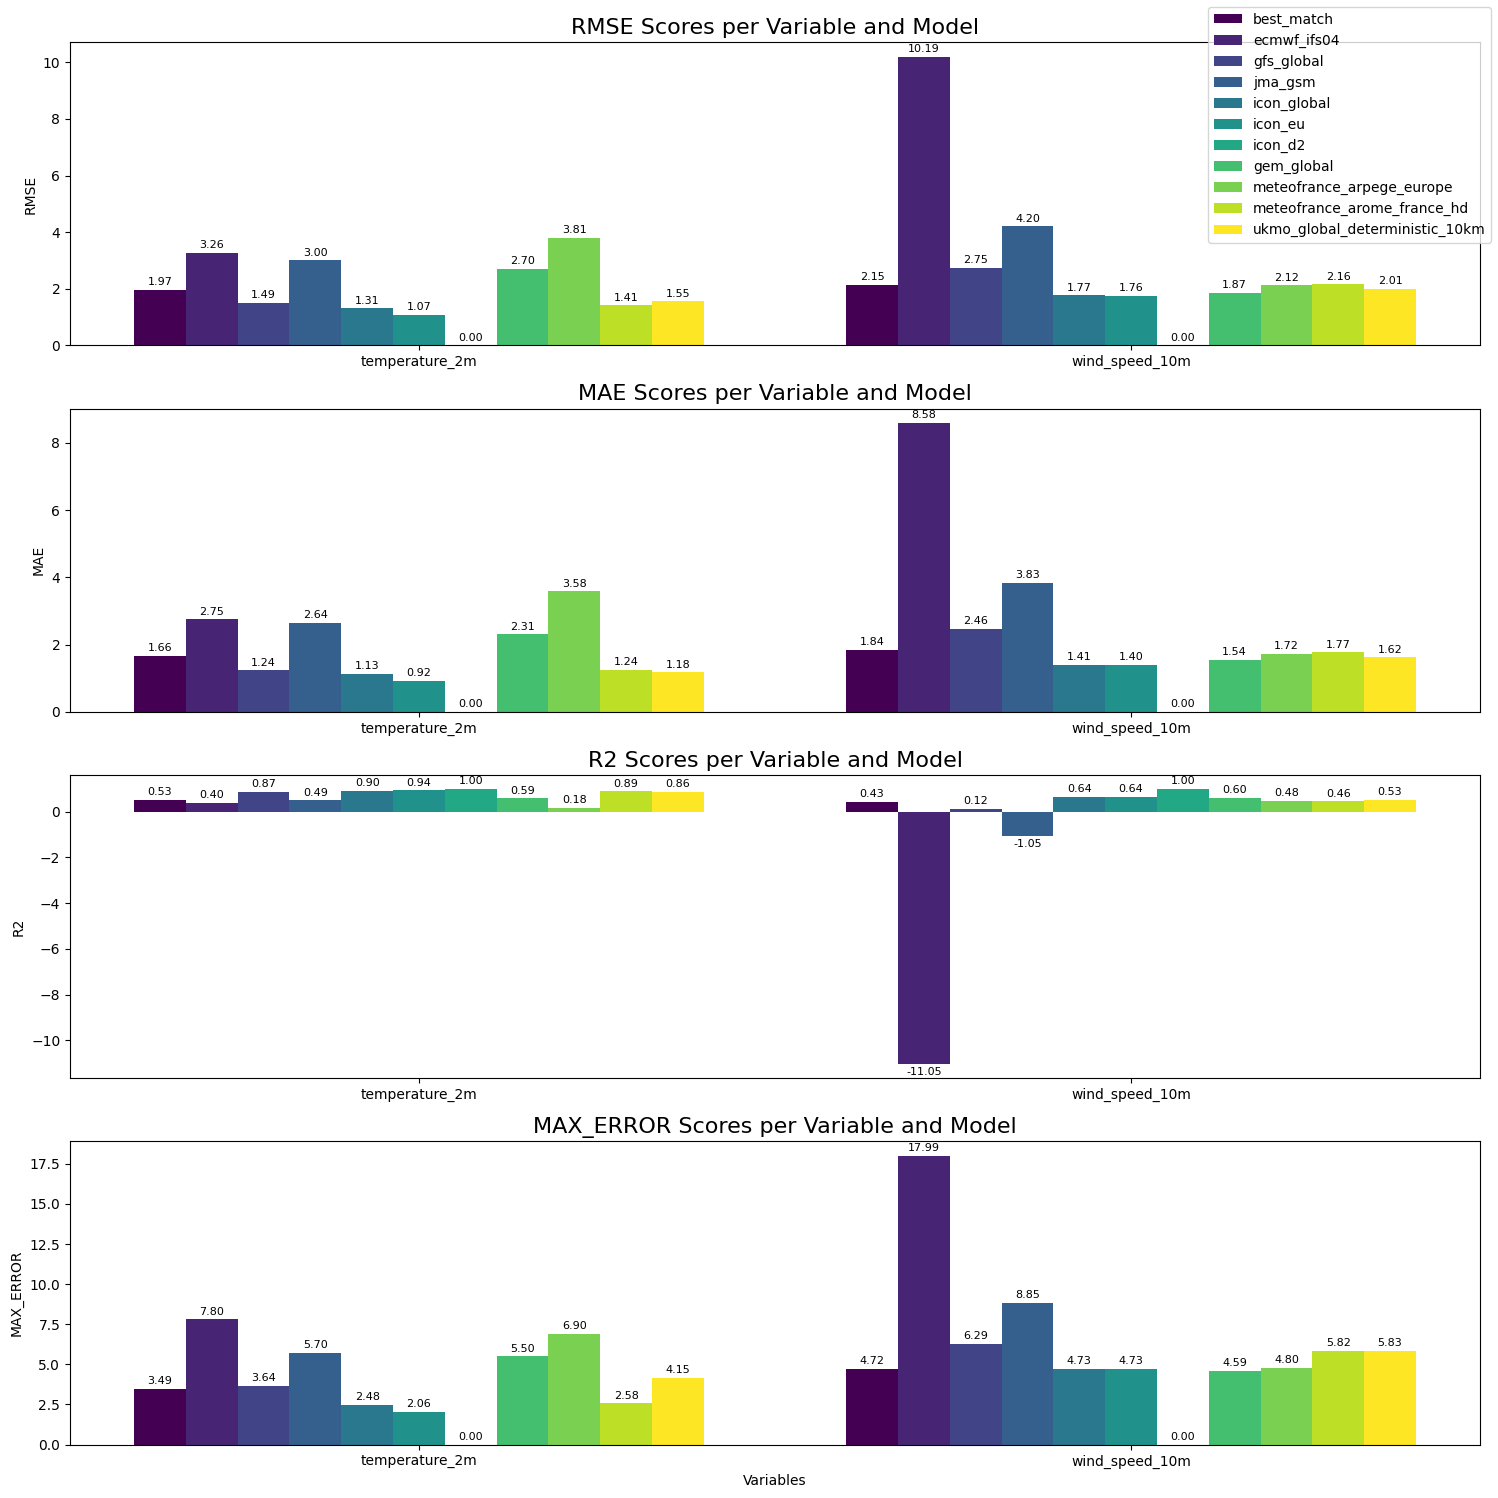

In [48]:
scores_nuevos, error_angulos_predicciones=obtener_metricas(models_hist['icon_d2'], models_pred)
graficar_metricas(scores_nuevos)


In [20]:
scores_probando_mejor=dict()
for mod in models_hist.keys():
  scores_probando_mejor[mod]=obtener_metricas(models_hist[mod], models_pred)

print(scores_probando_mejor)


Model best_match
maxima direccion 279.4622497558594
minima direccion 235.2440185546875
temperature_2m: rmse: 0.0, mae: 0.0, r2: 1.0, max_error:0.0
wind_speed_10m: rmse: 0.0, mae: 0.0, r2: 1.0, max_error:0.0

Model ecmwf_ifs04
maxima direccion 282.99462890625
minima direccion 209.7447967529297
temperature_2m: rmse: 2.2068550640315547, mae: 1.845418402735068, r2: 0.4242137753339619, max_error:4.3415000438690186
wind_speed_10m: rmse: 6.191447037906509, mae: 4.896869328557228, r2: -22.54910193760248, max_error:14.275469779968262

Model gfs_global
maxima direccion 285.2551574707031
minima direccion 204.44393920898438
temperature_2m: rmse: 1.1119710038658586, mae: 0.9561224281787872, r2: 0.8538157539199007, max_error:2.049999952316284
wind_speed_10m: rmse: 2.6360456613147734, mae: 2.0143702565407264, r2: -3.268702443055971, max_error:5.808330535888672

Model jma_gsm
maxima direccion 268.36346435546875
minima direccion 196.26028442382812
temperature_2m: rmse: 1.008713986541853, mae: 0.749602

In [21]:
# for mod in scores_probando_mejor.keys():
#   graficar_metricas(scores_probando_mejor[mod])

In [22]:
app = Dash('app1')

app.layout = html.Div([
    dcc.Dropdown(lista_modelos, lista_modelos[0], id='modelo', clearable=False),
    dcc.Graph(id='graph')
])

@app.callback(
    Output('graph', 'figure'),
    Input('modelo', 'value'))
def update_output_div(modelo):
    scores = scores_probando_mejor[modelo]
    lista_modelos_local = list(scores.keys())

    # Generar una lista de colores usando la escala "Viridis"
    if len(lista_modelos_local) > 1:
        norm = [i/(len(lista_modelos_local)-1) for i in range(len(lista_modelos_local))]
    else:
        norm = [0.5]
    color_scale = px.colors.sample_colorscale('Viridis', norm)
    model_colors_dict = dict(zip(lista_modelos_local, color_scale))

    # Definir las métricas a graficar
    metrics = ['rmse', 'mae', 'r2', 'max_error']

    # Crear figura con subplots (una fila por métrica)
    rows = len(metrics)
    fig = make_subplots(
        rows=rows, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.07,
        subplot_titles=[f'{metric.upper()} Scores per Variable and Model' for metric in metrics]
    )

    # Definir ancho de barra y función para calcular la posición (simulando el offset de grupos)
    bar_width = 0.8 / len(lista_modelos_local)
    def calculate_bar_positions(variable_index, model_index):
        group_center = variable_index
        offset = (model_index - len(lista_modelos_local) / 2 + 0.5) * bar_width
        return group_center + offset

    # Recorrer cada métrica y para cada modelo se crea una traza con las barras correspondientes a cada variable
    for metric_idx, metric in enumerate(metrics, start=1):
        for model_idx, model in enumerate(lista_modelos_local):
            x_vals = []
            y_vals = []
            # Por cada variable se calcula la posición y se extrae la puntuación
            for var_idx, variable in enumerate(atributos):
                score = scores[model][variable][metric]
                x_vals.append(calculate_bar_positions(var_idx, model_idx))
                y_vals.append(score)
            # Añadir traza de barra para la métrica actual
            fig.add_trace(
                go.Bar(
                    x=x_vals,
                    y=y_vals,
                    name=model,
                    marker_color=model_colors_dict[model],
                    width=[bar_width]*len(x_vals)
                ),
                row=metric_idx, col=1
            )
        # Configurar los ticks del eje x para que se centren en cada grupo (variable)
        fig.update_xaxes(
            tickmode='array',
            tickvals=[i for i in range(len(atributos))],
            ticktext=atributos,
            row=metric_idx, col=1
        )
        # Etiqueta para el eje y de cada subplot
        fig.update_yaxes(title_text=metric.upper(), row=metric_idx, col=1)

    # Actualizar layout general
    fig.update_layout(
        barmode='group',
        height=1200,
        width=1600,
        legend_title_text='Modelos',
        title_text="Métricas por Variable y Modelo",
        margin=dict(t=100)
    )

    return fig

if __name__ == '__main__':
    app.run_server(debug=True, port=8072)

<IPython.core.display.Javascript object>

In [64]:
"""Gráfica de datos para cada modelo y variable"""

app = Dash('app1')

app.layout = html.Div([

  dcc.Dropdown(lista_modelos, lista_modelos[0], id='modelo', clearable=False),
  dcc.Dropdown(atribs, atribs[0], id='atributo', clearable=False),
  dcc.Checklist(
          id='ver_error',
          options=[{'label': 'Cambiar a visualizar error', 'value': 'error'}],
          value=[]
  ),

  dcc.Graph(id='graph')
])


@app.callback(
    Output('graph', 'figure'),
    Input('modelo', 'value'),
    Input('atributo', 'value'),
    Input('ver_error', 'value'))
def update_output_div(modelo, atributo, ver_error):


  fig = go.Figure()

  # Convert models_hist to a DataFrame before merging
  datos_trabajo_model=pd.DataFrame(models_hist['icon_d2']).merge(models_pred[modelo], on="date", how="left", suffixes=("", f"_{modelo}"),)
  datos_trabajo_model.dropna(inplace=True)

  y_true=datos_trabajo_model[atributo]
  y_pred_model=datos_trabajo_model[atributo+f"_{modelo}"]

  if 'error' in ver_error:
    if atributo != 'wd_sin_10m' and atributo != 'wd_cos_10m':
      fig.add_trace(go.Scatter(y=y_true-y_pred_model, mode='lines', marker=dict(color='red'), name='Error'))
      fig.update_layout(
          title='Error historico vs prediccion',
          transition_duration=10,
          xaxis_title='tiempo (h)',
          yaxis_title=f'Error {atributo}'
      )
    else:
      fig.add_trace(go.Scatter(y=error_angulos_predicciones[modelo], mode='lines', marker=dict(color='red'), name='Error ángulo'))
      fig.update_layout(
      title='Diferencia entre ángulos',
      transition_duration=10,
      xaxis_title='tiempo (h)',
      yaxis_title=f'Error ángulos',
      yaxis=dict(range=[0, 180]) )
  else:
    fig.add_trace(go.Scatter(y=y_pred_model, mode='lines', marker=dict(color='red'), name='Predichas'))
    fig.add_trace(go.Scatter(y=y_true, mode='lines', marker=dict(color='blue'), opacity=0.5, name='Historicas'))

    fig.update_layout(
        title='Historico vs prediccion',
        transition_duration=10,
        xaxis_title='tiempo (h)',
        yaxis_title=f'{atributo}'
    )


  return fig



if __name__ == '__main__':
    app.run_server(debug=True, port=8073)


<IPython.core.display.Javascript object>